# First Steps in satkit: Propagating an Orbit with a TLE

This tutorial illustrates some of the basic functionalities of `satkit` (see the [documentation](https://satkit.readthedocs.io) for the latest or more advanced functionalities).

Many of the satellite mission analysis and design problems have four steps:

1. Initialise an orbit
2. Propagate the orbit to generate the trajectory over a duration
3. Do some analysis with this trajectory
4. Plot the results

In this tutorial we will go over these four basic steps to show how `satkit` works. While most of the functionality belongs to Orekit and the Orekit Python Wrapper, units management is provided by `satkit` through [pint](https://github.com/hgrecco/pint).

The first step is to initialise the environment where Orekit will run. This requires showing the system where the "Orekit Data File” is. Note that, the Orekit reference data zip directory may need to be changed with your configuration. Orekit reference data can also be downloaded as a [zip file](https://gitlab.orekit.org/orekit/orekit-data/-/archive/master/orekit-data-master.zip) from the main Orekit website or using the file download option of `init_satkit`. In the background, a Java VM is also initialised.


In [1]:
from pathlib import Path

# If satkit import fails, try to locate the module
import os

try:
    import satkit
except ModuleNotFoundError:
    os.chdir(os.path.join("..", ".."))
    os.getcwd()

from satkit import init_satkit, u

init_satkit(Path("data", "orekit-data", "orekit-data-reference.zip"), Path("..", ".."))

# Orekit / satkit init complete

PosixPath('/home/egemen/Projects/PycharmProjects/satkit/data/orekit-data/orekit-data-reference.zip')

The second step is to initialise the orbit. For this task we will generate a satellite on a geostationary orbit via `satkit` (seen below as Option 2). To illustrate the difference, we also have the option of initialising one from an existing TLE data (Option 1). We can choose between the two using the `use_tle` flag. This step initialises the orbit from the [Two-Line-Element](https://celestrak.com/NORAD/documentation/tle-fmt.php) data.

If needed, the up-to-date orbital elements of Turksat-4A can be retrieved from [Celestrak website](https://celestrak.org/NORAD/elements/gp.php?CATNR=39522).

In [2]:
from satkit.propagation.tle import TleFactory
from satkit.time.time import AbsoluteDateExt

from org.orekit.time import TimeScalesFactory
from org.orekit.propagation.analytical.tle import TLE

use_tle = False

if use_tle:
    # Option 1: use a TLE
    # ------------------------------

    # TURKSAT 4A
    line1 = "1 39522U 14007A   20193.17132507  .00000144  00000-0  00000+0 0  9992"
    line2 = "2 39522   0.0769 271.0842 0000679 241.5624 240.5627  1.00268861 23480"

    tle = TLE(line1, line2)

else:
    # Option 2: generate the TLE
    # ------------------------------

    epoch = AbsoluteDateExt("2020-07-11T04:06:42.486048Z", TimeScalesFactory.getUTC())
    longitude = 42.0 * u.deg

    tle = TleFactory.init_geo(
        epoch,
        longitude,
        launch_year=2014,
        launch_piece="A",
        launch_nr=7,
        sat_num=39522,
        classification="U",
        rev_nr=2348,
        el_nr=999,
    )

print (tle)

1 39522U 14007A   20193.17132507  .00000000  00000-0  00000-0 0  9994
2 39522   0.0000  33.2110 0000000   0.0000   0.0000  1.00273791 23480


The next step is to propagate the orbit. However, before diving into that, we need to do initialise the Earth-Fixed Frame (ITRF) and the `earth` object for later use.

In this example, we define the propagator `TLEPropagator` and associate our `tle` object with it. We then define an interval with a start time and a duration as well as an output stepsize. Note the use of units to keep track of various durations and how they are defined as `float` - Orekit is in Java and types are therefore strictly defined.

Finally, we propagate the orbit with a while loop, extracting new coordinates with `getPVCoordinates()` at the requested date and frame. The output array `pvt_list_itrf` keeps the discrete coordinates in the Earth-fixed (ITRF) coordinate frame.

In [3]:
from org.orekit.bodies import OneAxisEllipsoid
from org.orekit.utils import IERSConventions, Constants
from org.orekit.frames import FramesFactory
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.propagation.analytical.tle import TLEPropagator

#  prepare the itrf frame and the Earth
itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)
earth = OneAxisEllipsoid(
    Constants.WGS84_EARTH_EQUATORIAL_RADIUS, Constants.WGS84_EARTH_FLATTENING, itrf
)

# init SGP4
propagator = TLEPropagator.selectExtrapolator(tle)

# Propagation bounds and stepsize
init_date = AbsoluteDateExt(2020, 7, 11, 00, 0, 0.0, TimeScalesFactory.getUTC())
duration = 3. * u.day
stepsize = 120 * u.sec

# init empty data for the while loop
elapsed_time = 0 * u.sec
pvt_list_itrf = []

# Propagate into the future with the given stepsize
while elapsed_time <= duration:
    date = init_date + elapsed_time
    pvt_itrf = propagator.getPVCoordinates(date, itrf)
    pvt_list_itrf.append(pvt_itrf)
    elapsed_time += stepsize

print(f"First and last points: {pvt_list_itrf[0].getDate()} {pvt_list_itrf[-1].getDate()}")

First and last points: 2020-07-11T00:00:00.000Z 2020-07-14T00:00:00.000Z


The third step is to do some analysis with this trajectory. In theory, a geostationary orbit is *stationary* with respect to the rotating Earth. For this simple example, we can check whether this definition holds and whether the satellite moves in the Earth-fixed frame.

Therefore, the next step is to set a reference value and check how much the satellite position deviate in time from this reference position.

In [4]:
# Get ITRS coordinate at initial time
pvt_itrf_ref = propagator.getPVCoordinates(init_date, itrf)

#  extract the pos and velocity differences (and add units)
r_diff_list_itrf = [pvt_itrf.getPosition().subtract(pvt_itrf_ref.getPosition()).getNorm() for pvt_itrf in pvt_list_itrf] * u.m
v_diff_list_itrf = [pvt_itrf.getVelocity().subtract(pvt_itrf_ref.getVelocity()).getNorm() for pvt_itrf in pvt_list_itrf] * u.m / u.s

# Compute max position and velocity deviation
print(f"Max position deviation: {r_diff_list_itrf.max():~P}")
print(f"Max velocity deviation: {v_diff_list_itrf.max():~P}")

Max position deviation: 30804.20910509344 m
Max velocity deviation: 1.5946720993271566 m/s


This shows that the maximum deviation from the reference position was about 80 km for the sample TLE and about 30 km for the generated TLE. Similarly, the maximum velocity difference was more than 6 m/s for the sample TLE and 1.6 m/s for the generated TLE. These are not small differences, and they are actually due to the force model assumptions and orbit maintenance strategy in GEO.

However, we would like to understand these differences a bit more and this necessitates the final step: plotting the results.

Note that we need to initialise the `pint` units support to `matplotlib`. The rest is the boilerplate to get the figure the way we like it.

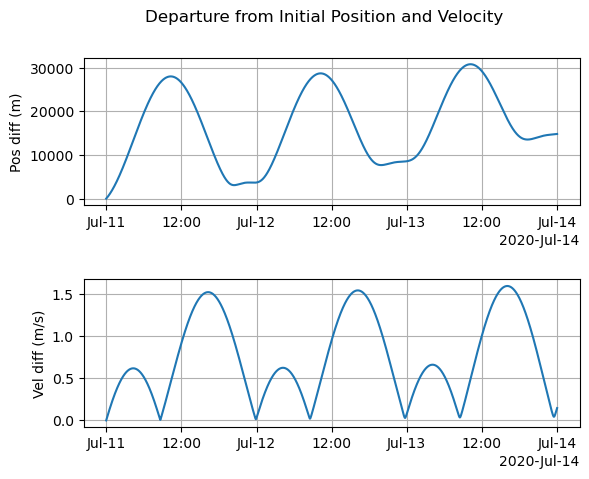

In [5]:
from orekit.pyhelpers import absolutedate_to_datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# init support for matplotlib
u.setup_matplotlib()

# Extract the date list for plotting
date_list = [absolutedate_to_datetime(pvt.getDate()) for pvt in pvt_list_itrf]

# prepare the plot
fig1 = plt.figure()
ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_subplot(2,1,2)
plt.suptitle("Departure from Initial Position and Velocity")
fig1.subplots_adjust(hspace=0.5)

ax1.grid()
ax1.set_ylabel(f"Pos diff ({r_diff_list_itrf.u:~P})")
ax1.plot(date_list, r_diff_list_itrf)
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

ax2.grid()
ax2.set_ylabel(f"Vel diff ({v_diff_list_itrf.u:~P})")
ax2.plot(date_list, v_diff_list_itrf)
ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

plt.show()

The results show a periodic motion with respect to the initial point, as well as a linear departure.

Perhaps more useful is to see this motion on a latitude-longitude plot, where we can see how *geostationary* the orbit really is. Usually satellite operators define a control box in this coordinate frame and make sure the satellite stays in this box.

For this we convert the ITRF position data to Latitude, Longitude and Altitude (`lla_list`) and extract the Latitude and Longitudes for plotting.

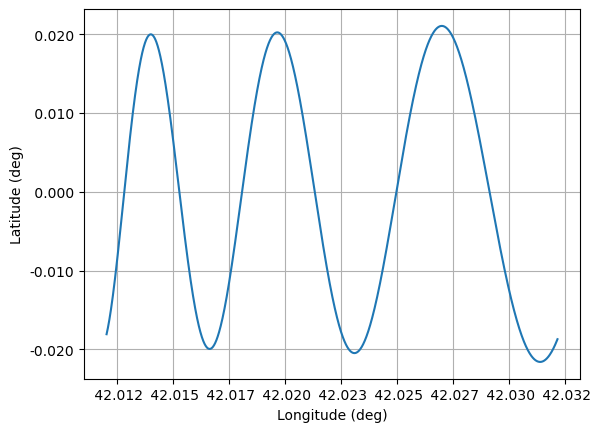

In [6]:
from matplotlib.ticker import FormatStrFormatter

# Generate lat-lon data
lla_list  = [earth.transform(pvt.getPosition(), earth.getBodyFrame(), pvt.getDate()) for pvt in pvt_list_itrf]

lla_lat_list = ([lla.getLatitude() for lla in lla_list] * u.rad).to("degrees")
lla_lon_list = ([lla.getLongitude() for lla in lla_list] * u.rad).to("degrees")

# Prepare lat-lon plot
fig2, ax = plt.subplots()

ax.grid()
ax.xaxis.set_major_formatter(FormatStrFormatter("% 3.3f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("% 3.3f"))
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
ax.plot(lla_lon_list , lla_lat_list)
plt.show()

We see further proof that there is a periodic motion as well as a linear drift. Any further analysis is beyond the scope of this simple example.

That said, we have shown the four fundamental steps of approaching a problem with satkit: initialisation, propagation, analysis and plotting the results.